In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys,os
import numpy as np
import matplotlib.pyplot as plt

##############
#For plotting
from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True
#rcParams['text.fontsize'] = 16

import george
from george import kernels
from george.kernels import ExpSquaredKernel

from scipy import optimize as op

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example Persues GP Fit

This is a first attempt at doing profile likelihood with a GP background model.  This notebook has three parts.  

1.  First, we load in the data and do a fit with the general GP model to get a sense for the underlying model.  Then, we will make Monte Carlo data from that underlying model.
2.  We will look at profile likelihood of the Monte Carlo data with a simple background model that consists of a double-exponential GP model with a large scale length.  This isn't going to work great.
3.  Will attempt to add in more structure to the sidebands by adding in a forest of lines on both sides of the putative signal window.

## First, we load in the data

1.  counts_data: the data counts
2.  errors: the guassian errors
3.  Epns: the energies in keV
4. z_pers: the redshift of the cluster
5.  E_3p5: the energy of the 3.55 keV line after accounting for redshift

In [9]:
work_dir = "/nfs/turbo/bsafdi/bsafdi/github/xmm_cluster/"
count_data=np.load(work_dir+"local/perseus_data_example.npy")
errors=np.load(work_dir+"local/perseus_data_example_errors.npy")
Epns=np.load(work_dir+"local/perseus_data_example_energies.npy")
z_pers = 0.016

E_3p5 = 3.55/(1+z_pers)

## Plot of the data

/home/bsafdi/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


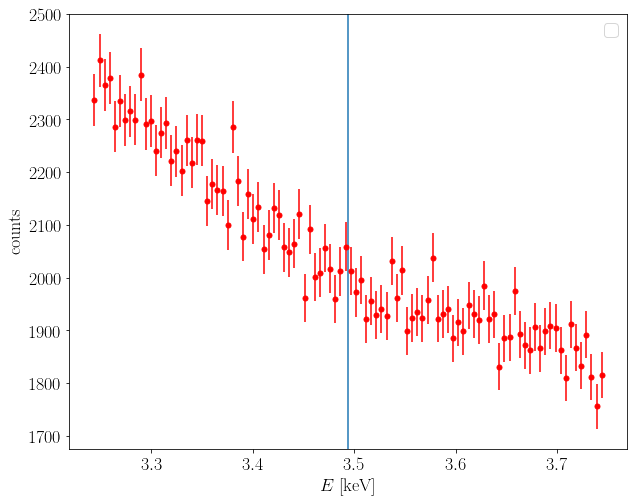

In [10]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Epns, count_data, errors, fmt='r.', markersize=10)
plt.axvline(E_3p5)
plt.ylabel(r'counts',fontsize=18)
plt.xlabel(r'$E$ [keV]',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc=1,fontsize=18)

## Do a fit and make MC

Here we will fit to an `ExpSquaredKernel` with a scale length of `0.05` keV.  We are doing this to get a model to make MC from.

In [11]:
k_back = kernels.ConstantKernel(10)*kernels.ExpSquaredKernel(0.05**2) #kernels.ConstantKernel(4)* #66.0**2 * kernels.ExpSquaredKernel(67.0**2)


gp_back = george.GP(k_back, mean=np.mean(count_data))
gp_back.compute(Epns,yerr= errors)
print "params = ",gp_back.kernel.get_parameter_vector()
print(gp_back.lnlikelihood(count_data))




params =  [10.         -5.99146455]
-537.9679213270621


### Use scipy.optimize.minimize to get best-fit normalization

We maximimize the log likelihood

In [12]:
def nll_back(p):
    # Update the kernel parameters and compute the likelihood.
    gp_back.kernel.set_parameter_vector(p)
    gp_back.compute(Epns,yerr= errors)
    ll = gp_back.lnlikelihood(count_data, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

def nll_back_A(A_vec):
    p = np.array([A_vec[0],np.log(0.05**2)])
    return nll_back(p)

results = op.minimize(nll_back_A, 10.0) #,jac=grad_nll) #, jac=grad_nll) #,bounds=((0,12),(-0.1,+10)))
print results.x

[9.69886776]


### Plot of the data and our best-fit background model

We will use this model for MC

(1200, 2500)

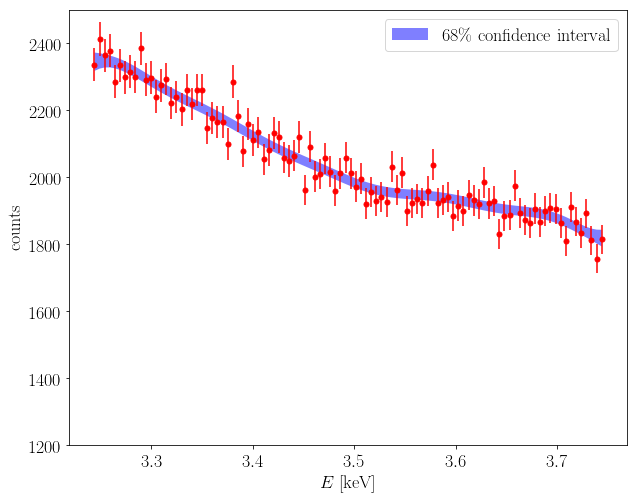

In [13]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
meanGP_back, covGP_back = gp_back.predict(count_data, Epns)
stdGP_back = np.sqrt(np.diag(covGP_back))


# x = Epns
# y = xm0._obs_data
fig = plt.figure(figsize=(10,8))
#plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(Epns, count_data, errors, fmt='r.', markersize=10) #, label=u'Observations')
plt.fill(np.concatenate([Epns, Epns[::-1]]),
        np.concatenate([meanGP_back -  1.0 * stdGP_back,
                       (meanGP_back +  1.0 * stdGP_back)[::-1]]),
        alpha=.5, fc='b', ec='None', label=r'68\% confidence interval')
plt.ylabel(r'counts',fontsize=18)
plt.xlabel(r'$E$ [keV]',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(-10, 20)
plt.legend(loc=1,fontsize=18)
plt.ylim(1200,2500)

#plt.savefig(plots_dir +"GP.pdf",bbox_inches="tight")

Below is our function to make Monte Carlo data

In [14]:
def make_fake_data():
    return np.random.normal(loc=meanGP_back,scale=errors)

### Plot an example fake dataset

(1200, 2500)

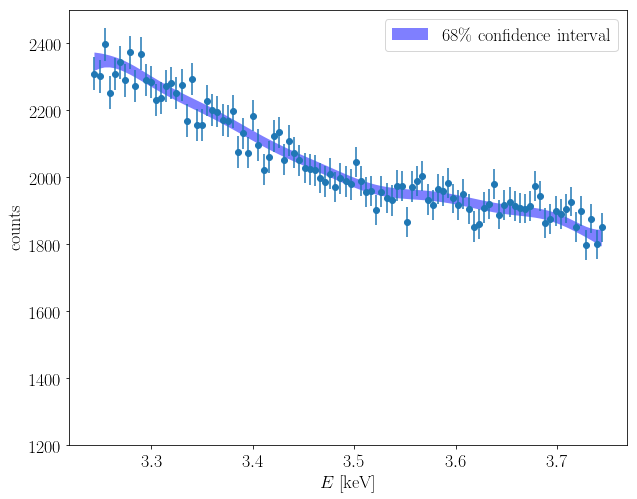

In [15]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Epns,make_fake_data(),errors,fmt="o")
plt.fill(np.concatenate([Epns, Epns[::-1]]),
        np.concatenate([meanGP_back -  1.0 * stdGP_back,
                       (meanGP_back +  1.0 * stdGP_back)[::-1]]),
        alpha=.5, fc='b', ec='None', label=r'68\% confidence interval')

plt.ylabel(r'counts',fontsize=18)
plt.xlabel(r'$E$ [keV]',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(-10, 20)
plt.legend(loc=1,fontsize=18)
plt.ylim(1200,2500)


# First do simple profile likelihood class
Here we only allow for a single smooth GP (exp squared) background model.  

The function `gauss_mod` below is our signal model.  We will do profile likelihood by subtracting this model from the data.

The class `simple_profile_likelihood` is used to actually perform the profile likelihood.  This sets up an instance of `george.GP` with a Kernel consisting of a `ConstantKernel` and a `ExpSquaredKernel` with a wavelength of 1 keV.

In [16]:
# This is going to be our signal model
def gauss_mod(x,xc,A,lam=0.05):
    return A*np.exp(-(x-xc)**2/2./lam**2)*np.sqrt(2/np.pi/lam**2)

In [17]:
lam_long = 1.0
class simple_profile_likelihood:
    def __init__(self,data,lam_long=1.0):
        self._data = data
        self._data_orig = data
        self._lam_long = lam_long
        self._init_gp()
        
        
    def _init_gp(self):
        k_long = kernels.ConstantKernel(10)*kernels.ExpSquaredKernel(self._lam_long**2)
        self._gp = george.GP(k_long, mean=np.mean(self._data))
        self._gp.compute(Epns,yerr= errors)
        
        
    def _nll(self,A_vec):
        p = np.array([A_vec[0],np.log(lam_long**2)])
        # Update the kernel parameters and compute the likelihood.
        self._gp.kernel.set_parameter_vector(p)
        self._gp.compute(Epns,yerr= errors)
        ll = self._gp.lnlikelihood(self._data, quiet=True)
        # The scipy optimizer doesn't play well with infinities.
        return -ll if np.isfinite(ll) else 1e25
    
    def compute_LL(self,A_sig):
        sig = gauss_mod(Epns,E_3p5,A_sig)
        data = self._data_orig - sig
        self._data = data
        self._init_gp()
        
        results = op.minimize(self._nll, 10.0) #,jac=grad_nll) #, jac=grad_nll) #,bounds=((0,12),(-0.1,+10))
        LL = self._gp.lnlikelihood(self._data)
        
        return LL
    
    def get_best_fit(self,A_sig):
        self._LL = self.compute_LL(A_sig)
        meanGP, covGP = self._gp.predict(self._data, Epns)
        stdGP = np.sqrt(np.diag(covGP))

        sig = gauss_mod(Epns,E_3p5,A_sig)
        return meanGP + sig, stdGP,sig
    
    def compute_chi2(self,A_sig):
        back,_,sig = self.get_best_fit(A_sig)
        chi2 = np.sum( (back-sig-self._data)**2/errors**2)
        return chi2
        
        
        
        

### Make and analyze fake data under null hypothesis

    Below we make null fake fata `fake_data` and then we show an example fit under null hypothesis and signal hypothesis

In [18]:
fake_data = make_fake_data()
sp = simple_profile_likelihood(fake_data)

In [19]:
mean_null,_,_ = sp.get_best_fit(0.0)
mean_sig,_,sig = sp.get_best_fit(10.0)

(3.244094488188976, 3.744094488188976)

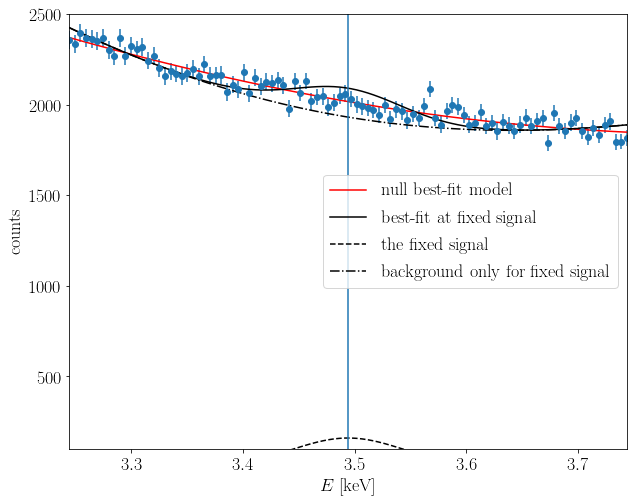

In [20]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Epns,fake_data,errors,fmt="o")
plt.plot(Epns,mean_null,'r-',label="null best-fit model")
plt.plot(Epns,mean_sig,'k-',label="best-fit at fixed signal")
plt.plot(Epns,sig,'k--',label="the fixed signal")
plt.plot(Epns,mean_sig-sig,'k-.',label="background only for fixed signal")
plt.axvline(E_3p5)


plt.ylabel(r'counts',fontsize=18)
plt.xlabel(r'$E$ [keV]',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(-10, 20)
plt.legend(fontsize=18)
plt.ylim(100,2500)
plt.xlim(Epns[0],Epns[-1])


### Now we do profile likelihood

We plot the profile likelihood as a function of the putative (dimensionless) signal strenght $A$.  As seen below, the background model doesn't have enough flexibility since we too heavily constrain the signal hypothesis.  Note that the data is constructed under the null hypothesis.

We use both the likelihood from george and the chi2 computed directly by hand.

In [21]:
A_array = np.linspace(-10,10,20)
LL_array = np.zeros(20)
chi2_array = np.zeros(20)
for i in range(20):
    chi2_array[i] = sp.compute_chi2(A_array[i])
    LL_array[i] = sp._LL


KeyboardInterrupt: 

# Custom Kernel

In [22]:
from george.kernels import XrayLineKernel

In [65]:
lam_long = 1.0
class gibbs_profile_likelihood:
    def __init__(self,data,lam_long=1.0,lout=0.05,lin=1.0):
        self._data = data
        self._data_orig = data
        self._lam_long = lam_long
        self._lout = lout
        self._lin = lin
        self._init_gp()
        
        
    def _init_gp(self):  
        k = kernels.ConstantKernel(10)*kernels.ExpSquaredKernel(self._lam_long**2) + kernels.ConstantKernel(10)*kernels.XrayLineKernel(lin=self._lin,lout=self._lout,Eline=E_3p5,Ewidth=0.1,r=100.)
        #k = kernels.ConstantKernel(10)*kernels.ExpSquaredKernel(self._lam_long**2) #+ kernels.ConstantKernel(10)*kernels.XrayLineKernel(lin=5.0,lout=1.0,Eline=E_3p5,Ewidth=0.15,r=100.)

#         k = kernels.ConstantKernel(10)*kernels.ExpSquaredKernel(self._lam_long**2) + kernels.ConstantKernel(10)*kernels.XrayLineKernel(lin=5.0,lout=1.0,Eline=E_3p5,Ewidth=0.15,r=100.)
        self._gp = george.GP(k, mean=np.mean(self._data))
        self._gp.compute(Epns,yerr= errors)
        
        
#     def _nll(self,A_vec):
#         p = np.array([A_vec[0]],np.log(lam_long**2))
# #         p = np.array([A_vec[0],np.log(lam_long**2),A_vec[1],5.0,1.0,E_3p5,0.15,100.])
#         # Update the kernel parameters and compute the likelihood.
#         self._gp.kernel.set_parameter_vector(p)
#         self._gp.compute(Epns,yerr= errors)
#         ll = self._gp.lnlikelihood(self._data, quiet=True)
#         # The scipy optimizer doesn't play well with infinities.
#         return -ll if np.isfinite(ll) else 1e25
    
    def _nll(self,A_vec):
        p = np.array([A_vec[0],np.log(self._lam_long**2),A_vec[1],self._lin,self._lout,E_3p5,0.1,100.])

#         p = np.array([A_vec[0],np.log(self._lam_long**2)])
        # Update the kernel parameters and compute the likelihood.
        self._gp.kernel.set_parameter_vector(p)
        self._gp.compute(Epns,yerr= errors)
        ll = self._gp.lnlikelihood(self._data, quiet=True)
        # The scipy optimizer doesn't play well with infinities.
        return -ll if np.isfinite(ll) else 1e25
    
    def _nll_sig(self,x):
        A = x[:2]
        S = x[2]
        sig = gauss_mod(Epns,E_3p5,S)
        data = self._data_orig - sig
        self._data = data
        return - self._nll(A)
    
    def _configure_multinest(self):
        self._theta_min = [1,-30,-10]
        self._theta_max = [20,20,10]
        
        self._theta_interval = list(np.array(self._theta_max)-np.array(self._theta_min))
    
    def _prior_cube(self, cube, ndim=1, nparams=1):
        """ Cube of priors in the format required by MultiNest
        """
        for i in range(ndim):
            cube[i] = cube[i] * self._theta_interval[i] + self._theta_min[i]
        return cube
    
    def perform_multinest_scan(self,chains_dir,nlive):
        self._configure_multinest()
        
        # Create chains directory if it doesn't exist
        self._chains_dir = chains_dir
        if not os.path.exists(chains_dir):
            os.makedirs(chains_dir)
        
        # Define all functions required by multinest
        prior_cube = lambda cube,ndim,nparams: self._prior_cube(cube,ndim=ndim,nparams=nparams)
        log_likelihood = lambda x,ndim,nparams: self._nll_sig(x)
        n_params = len(self._theta_min)

        # Multinest run options
        pymultinest_options = {'importance_nested_sampling': False,
                        'resume': False, 'verbose': True,
                        'sampling_efficiency': 'model',
                        'init_MPI': False, 'evidence_tolerance': 0.5,
                        'const_efficiency_mode': False}

        pymultinest.run(log_likelihood, prior_cube, n_params,outputfiles_basename = chains_dir,n_live_points = nlive, **pymultinest_options)
        
        
    def analyze_multinest(self,chains_dir):
        """ Tools for analyzing Multinest output
            Can run this after configure_for_scan without running perform scan
        """
        self._configure_multinest()

        self.n_params = len(self._theta_min)
        An = pymultinest.Analyzer(self.n_params,outputfiles_basename=chains_dir)
        max_LL_multinest = An.get_best_fit()['log_likelihood']
        best_fit_params = An.get_best_fit()['parameters'] 
        self.s = An.get_stats()
        
        # Load the chains (discretized posterior)
        chain_file = chains_dir + 'post_equal_weights.dat'
        self.samples = np.array(np.loadtxt(chain_file)[:, :-1]) 

        # Determine the median value of each parameter
        self.medians = [self.s['marginals'][i]['median'] for i in range(self.n_params)] 
        self.An = An
        self.best_fit_params = best_fit_params
        self.max_LL_multinest = max_LL_multinest

        # Get the log-evidence and associated error
        self.lge = self.s['nested sampling global log-evidence']
        self.lge_err = self.s['nested sampling global log-evidence error']
    
    def compute_LL(self,A_sig):
        sig = gauss_mod(Epns,E_3p5,A_sig)
        data = self._data_orig - sig
        self._data = data
        self._init_gp()
        
#         p0 = np.array([10.0,10.0])
        p0 = np.array([10.0,10.0])
        results = op.minimize(self._nll, p0) #,jac=grad_nll) #, jac=grad_nll) #,bounds=((0,12),(-0.1,+10))
        LL = self._gp.lnlikelihood(self._data)
        
        return LL
    
    def get_best_fit(self,A_sig):
        self._LL = self.compute_LL(A_sig)
        meanGP, covGP = self._gp.predict(self._data, Epns)
        stdGP = np.sqrt(np.diag(covGP))

        sig = gauss_mod(Epns,E_3p5,A_sig)
        return meanGP + sig, stdGP,sig
    
    def compute_chi2(self,A_sig):
        back,_,sig = self.get_best_fit(A_sig)
        chi2 = np.sum( (back-sig-self._data)**2/errors**2)
        return chi2
        
        
# #     def _nll(self,A_vec):
# #         p = np.array([A_vec[0],np.log(lam_long**2)])
# #         # Update the kernel parameters and compute the likelihood.
# #         self._gp.kernel.set_parameter_vector(p)
# #         self._gp.compute(Epns,yerr= errors)
# #         ll = self._gp.lnlikelihood(self._data, quiet=True)
# #         # The scipy optimizer doesn't play well with infinities.
# #         return -ll if np.isfinite(ll) else 1e25
    
#     def compute_LL(self,A_sig):
#         sig = gauss_mod(Epns,E_3p5,A_sig)
#         data = self._data_orig - sig
#         self._data = data
#         self._init_gp()
        
#         results = op.minimize(self._nll, 10.0) #,jac=grad_nll) #, jac=grad_nll) #,bounds=((0,12),(-0.1,+10))
#         LL = self._gp.lnlikelihood(self._data)
        
#         return LL
    
#     def get_best_fit(self,A_sig):
#         self._LL = self.compute_LL(A_sig)
#         meanGP, covGP = self._gp.predict(self._data, Epns)
#         stdGP = np.sqrt(np.diag(covGP))

#         sig = gauss_mod(Epns,E_3p5,A_sig)
#         return meanGP + sig, stdGP,sig
        
        
        

In [34]:
fake_data = make_fake_data()
sp = gibbs_profile_likelihood(fake_data)#gibbs_profile_likelihood(fake_data)

In [29]:
mean_null,_,_ = sp.get_best_fit(0.0)
mean_sig,_,sig = sp.get_best_fit(10.0)

(3.244094488188976, 3.744094488188976)

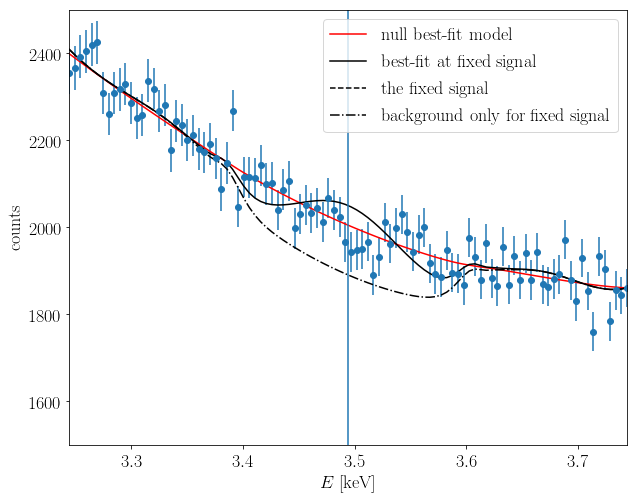

In [30]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(Epns,fake_data,errors,fmt="o")
plt.plot(Epns,mean_null,'r-',label="null best-fit model")
plt.plot(Epns,mean_sig,'k-',label="best-fit at fixed signal")
plt.plot(Epns,sig,'k--',label="the fixed signal")
plt.plot(Epns,mean_sig-sig,'k-.',label="background only for fixed signal")
plt.axvline(E_3p5)


plt.ylabel(r'counts',fontsize=18)
plt.xlabel(r'$E$ [keV]',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(-10, 20)
plt.legend(fontsize=18)
plt.ylim(1500,2500)
plt.xlim(Epns[0],Epns[-1])


## Multinest Attempt

In [66]:
import pymultinest, corner

In [67]:
fake_data = make_fake_data()
sp = gibbs_profile_likelihood(fake_data)

#gibbs_profile_likelihood(fake_data)

In [ ]:
chains_tmp = work_dir + "local/chains_t"
sp.perform_multinest_scan(chains_tmp,400)

In [ ]:
sp.analyze_multinest(chains_tmp)

In [ ]:
corner.corner(sp.samples,show_titles=True, title_kwargs={"fontsize": 12},labels=[r"$A_1$",r"$A_2$",r"$A_{\rm sig}$"],quantiles=[0.16,0.5,0.84]);

## Profile likelihood

In [201]:
A_array = np.linspace(-10,10,20)
LL_array = np.zeros(20)
chi2_array = np.zeros(20)
for i in range(20):
    print "On i = ",i
    chi2_array[i] = sp.compute_chi2(A_array[i])
    LL_array[i] = sp._LL


On i =  0
On i =  1
On i =  2
On i =  3
On i =  4
On i =  5
On i =  6
On i =  7
On i =  8
On i =  9
On i =  10
On i =  11
On i =  12
On i =  13
On i =  14
On i =  15
On i =  16
On i =  17
On i =  18
On i =  19


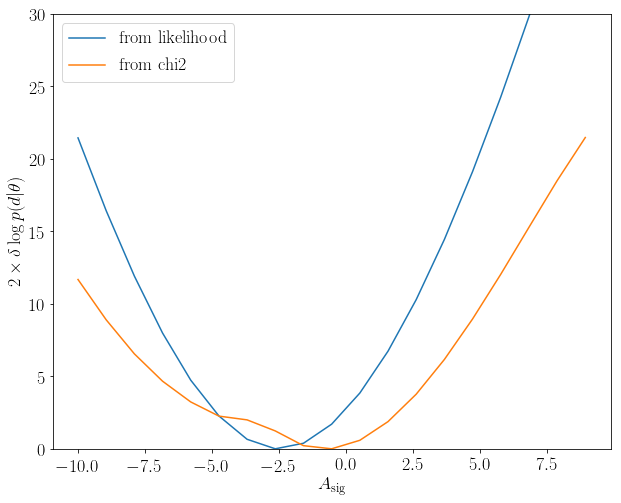

In [202]:
# plt.plot(A_array,-2*(LL_array-np.max(LL_array)))
# plt.plot(A_array,chi2_array - np.min(chi2_array))
# plt.ylim(0,30)

fig = plt.figure(figsize=(10,8))

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(A_array[0:19],-2*(LL_array[0:19]-np.max(LL_array[0:19])),label="from likelihood")
plt.plot(A_array[0:19],chi2_array[0:19] - np.min(chi2_array[0:19]),label="from chi2")
plt.ylim(0,30)
plt.xlabel(r"$A_{\rm sig}$",fontsize=18)
plt.ylabel(r"$2 \times \delta \log p(d|\theta)$",fontsize=18)
plt.legend(fontsize=18)

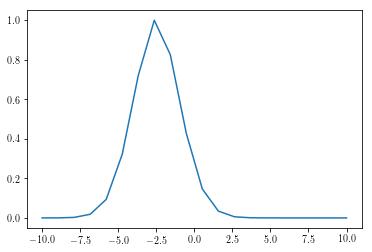

In [203]:
plt.plot(A_array,np.exp(LL_array-np.max(LL_array)))

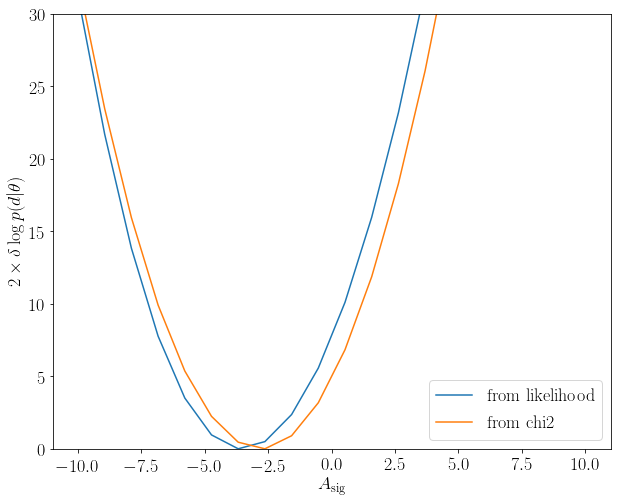

In [155]:
fig = plt.figure(figsize=(10,8))

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(A_array,-2*(LL_array-np.max(LL_array)),label="from likelihood")
plt.plot(A_array,chi2_array - np.min(chi2_array),label="from chi2")
plt.ylim(0,30)
plt.xlabel(r"$A_{\rm sig}$",fontsize=18)
plt.ylabel(r"$2 \times \delta \log p(d|\theta)$",fontsize=18)
plt.legend(fontsize=18)